# Homework5

Words before the real parts beginning:
- `CMakeLists.txt` enables the google tests and the compiler Sanitizer. But I use this cmake **only in delevepment**, so not for evaluation.
- As said, Unit tests (google tests) can be found in: `Tester.cpp`, ` TestSynchronization.cpp`. Use cmake to build them and run them.
- I did some basic c++ code refactoring but not complete. The code style is still not cool and has plenty of duplicated stuff. 
- I only use the given makefile for evaluation.

# Synchronization

We are implementing and evaluating several locking / synchronization strategies:
- `coarse`
- `coarseRW`
- `coupling`
- `couplingRW`
- `optimistic`
- `optimisticCoupling`

These different approaches are applied in a singly linked list. The detail can be found in the tutorial slide as well as in the lecture slide. So generally, we just add additionally coding for locking and synchronization on the implementation of the singly linked list. Thus the six classes differ only at the locking approaching to ensure the multi-threading safety, here comes the duplicated coded for common parts.

I did the evaluation on dataset, which has two scenarios: read-only workload and read-insert-delete-mixed workload.
The `optimistic` and `optimisticCoupling` have 10 attempts to do the work in optimistic way, if still no success, just fail back to non-optimistic way.

(However we do have a non-multi-threading-capable implementation: `nosync`. It is the baseline in the evaluation.)


---

## Dataset: the default given dataset

This dataset is just the default given one with the following configurations:

```c++
// Number of (non-unique) values, which are inserted into the list. Feel free to change it
static constexpr uint32_t operations = 10e6;
// Define the domain range of the values. ToDo: Play around with this parameter.
static constexpr uint32_t domain = 16;

  for (uint32_t i = 0; i < operations; i++) work[i] = random() % domain; // Create elements & map them to the domain
  // Init list-based set. Insert only a small subset into the list-based set.
  for (uint32_t i = 0; i < domain * 0.75; i++) {
    const int64_t value = random() % domain;
    list.insert(value);
  }
```

We can infer the initial list is rather short, so very naively, there could be a dense locking, where multiple threads highly contest for the mutex at a same node.

### Workload Evaluation

#### nosync

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.10| 461653152.00| 295175249.00| 634457.00|  477135.00|    9931006.00| 103167204.00| 0.64|  1.00|  4.47 | 
|       2|     0.06| 464790639.00| 295981574.00| 652364.00|  502453.00|    9942584.00| 111427874.00| 0.64|  2.00|  4.17 | 
|       5|     0.02| 461852878.00| 295707340.00| 664968.00|  501923.00|    9929977.00| 115793082.00| 0.64|  5.00|  3.99 | 
|      10|     0.01| 465435928.00| 296665169.00| 702772.00|  501890.00|    9952468.00| 117517955.00| 0.64|  9.92|  3.96 | 
|      15|     0.01| 540848097.00| 297697169.00| 737067.00|  499192.00|   10314701.00| 136991853.00| 0.55|  15.05|  3.95 | 
|      20|     0.01| 568440935.00| 298373323.00| 776153.00|  499419.00|   10416901.00| 144114872.00| 0.52|  15.85|  3.94 | 
|      30|     0.01| 593267533.00| 302374739.00| 846295.00|  514438.00|   10481157.00| 150373565.00| 0.51|  17.93|  3.95 | 
|      40|     0.01| 30904388.00 |  15260743.00|  38466.00|   27303.00|     530007.00|   7730385.00| 0.49|   1.00|  4.00 | 

<br>
<br>

#### Coarse Lock

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.20|   887799749.00| 1145357088.00|   640236.00|   524914.00|    9588996.00| 203324378.00| 1.29| 1.00|  4.37 |
|       2|     0.71|  6154471817.00| 2110001854.00|  15084958.00|  518456.00|   13586460.00| 1422280920.00| 0.34| 2.00|  4.33 |
|       5|     0.77| 12716991052.00| 3648022482.00|  50740618.00|  525106.00|   21548226.00| 3288821787.00| 0.29| 4.28|  3.87 |
|      10|     0.86| 28105440940.00| 5422065448.00| 112252867.00|  527028.00|   28577494.00| 7280588544.00| 0.19| 8.48|  3.86 |
|      15|     1.00| 51315245099.00| 6737439132.00| 151382120.00|  538910.00|   31045886.00| 13177395991.00| 0.13| 13.15| 3.89 |
|      20|     1.07| 75901003707.00| 7675111735.00| 170611482.00|  552907.00|   32805654.00| 19360359976.00| 0.10| 18.05| 3.92 |
|      30|     1.06| 79705422021.00| 7917806378.00| 174651653.00|  586428.00|   33682207.00| 20112332516.00| 0.10| 19.03| 3.96 |
|      40|     1.04| 82902000952.00| 8064431524.00| 169229608.00|  588412.00|   32663847.00| 20731824077.00| 0.10| 20.00| 4.00 |

`Coarse Lock` works badly, when we look at the `IPC`.

<br>
<br>

#### Coarse RW Lock

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.18| 776657418.00| 835286893.00| 638764.00|  522228.00|    9536761.00| 176711395.00| 1.08| 1.00| 4.40 | 
|       2|     0.63| 5435337571.00| 836505078.00| 15921054.00|  518781.00|    3263248.00| 1261957530.00| 0.15| 2.00| 4.31 | 
|       5|     0.59| 11844438483.00| 838634037.00| 16172250.00|  514686.00|    2937686.00| 2961459951.00| 0.07| 5.00| 4.00 | 
|      10|     0.60| 24039593738.00| 842585330.00| 16676688.00|  519401.00|    2721301.00| 6011117571.00| 0.04| 10.00| 4.00 | 
|      15|     0.55| 32890440478.00| 845867639.00| 15045015.00|  516588.00|    3049066.00| 8224317104.00| 0.03| 14.99| 4.00 | 
|      20|     0.50| 39223424677.00| 847631850.00| 13569841.00|  527303.00|    3346581.00| 9808274372.00| 0.02| 19.56| 4.00 | 
|      30|     0.50| 40008173463.00| 860368363.00| 13887476.00|  538837.00|    3447162.00| 10004783876.00| 0.02| 19.98| 4.00 | 
|      40|     0.50| 40122520346.00| 871975205.00| 14197651.00|  553947.00|    3512311.00| 10033938272.00| 0.02| 19.95| 4.00 | 

`Coarse RW Lock` works badly, when we look at the `IPC`. **It is even worse than the `Coarse Lock`.** 

(Following wording is not comparing `Coarse RW Lock` and `Coarse Lock`. Just wording on the `Coarse RW Lock`.)

Somehow we can naively think the shared-lock is more performant than the exclusive-lock in read-only workload. But that is **not true** in multi-threading context. We should look at how the shared-lock (read-write lock) is implemented, then we notice there **can be** like a int (also has to be atomic) counting how many reader acquired this rw-lock. So in multi-threading case, this lock as well as the int counting inside the lock is loaded to all CPU cores. When each cores want to have this lock and update this int counter, a synchronization is happening to make this int counter thread-safe. **This kills the performance,** since all the cores have to communicate each other to ensure the correctness of this tiny int counter. 

An additional to this point: [cache false sharing](https://en.wikipedia.org/wiki/False_sharing) is happening to each core running multiple threads. These threads hosted by the same core are also sharing the caches of this core. Each threads also has to synchronize to update / read this int counter. Referring the cache protocol and hyper-threading knowledge, this *false sharing* poses a negative impact on the performance.

**Thus, use a single shared-lock (rw-lock) in reading-intensive-workload is a very bad idea in multi-threading context**, this approach is has no "hardware-awareness" and is not "hardware-friendly".

(But it turns out the performance is okay :D. The reason can be that I use a spinning `spin_rw_mutex`.)

<br>
<br>

#### Lock Coupling

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.76| 3389982915.00| 4330379795.00| 666063.00|  498783.00|    9576959.00| 758408775.00| 1.28| 1.00| 4.47 |
|       2|     4.74| 23671732943.00| 12096699726.00| 177671837.00|  555978.00|   32156040.00| 6067099274.00| 0.51| 1.28| 3.90 | 
|       5|     9.09| 21500044135.00| 13025408006.00| 234561816.00|  447116.00|   33284232.00| 6369353213.00| 0.61| 0.70| 3.38 |
|      10|     3.75| 17715895877.00| 11641270270.00| 181011463.00|  605900.00|   29251187.00| 5165657407.00| 0.66| 1.38| 3.43 |
|      15|     3.61| 16950193484.00| 11131360355.00| 184621863.00|  605652.00|   28225889.00| 4941148490.00| 0.66| 1.37| 3.43 |
|      20|     3.59| 16773085325.00| 10942359569.00| 192439688.00|  608443.00|   28150010.00| 4883407968.00| 0.65| 1.36| 3.43 |
|      30|     3.55| 16711481244.00| 10858974734.00| 194611240.00|  617332.00|   28221502.00| 4853704305.00| 0.65| 1.37| 3.44 |
|      40|     7.18| 2492365279.00| 1471424477.00| 30620845.00|   55125.00|    3814865.00| 723219451.00| 0.59| 0.10| 3.45 |

<br>
<br>

#### RW Lock Coupling

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.67| 2980393091.00| 2863389709.00| 664112.00|  542557.00|    9896580.00| 667696883.00| 0.96| 1.00| 4.46 | 
|       2|     3.99| 34814148920.00| 2871705614.00| 338691550.00|  532239.00|    6846378.00| 7982302346.00| 0.08| 2.00| 4.36 | 
|       5|     4.22| 33750847130.00| 1142522168.00| 243134944.00|  208417.00|    1664530.00| 8437864072.00| 0.03| 2.00| 4.00 | 
|      10|     3.76| 15020331869.00| 286343108.00| 68055868.00|   48240.00|     361738.00| 3755118775.00| 0.02| 1.00| 4.00 | 
|      15|     2.84| 11365011399.00| 188801098.00| 28917076.00|   31752.00|     327224.00| 2841283503.00| 0.02| 1.00| 4.00 | 
|      20|     2.25| 178135736110.00| 2907212134.00| 451359400.00|  540369.00|    4919439.00| 44536269187.00| 0.02| 19.81| 4.00 | 
|      30|     2.24| 179242537939.00| 2917348281.00| 450954210.00|  552233.00|    4977978.00| 44813893122.00| 0.02| 19.99| 4.00 | 
|      40|     2.24| 179338704164.00| 2923693713.00| 451545092.00|  570674.00|    5020563.00| 44839795214.00| 0.02| 19.99| 4.00 | 

<br>
<br>

#### Optimistic

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.23| 1012808715.00| 1436613115.00| 640790.00|  512308.00|    9580297.00| 228113715.00| 1.42| 1.00| 4.44 | 
|       2|     0.78| 6739493093.00| 1499236115.00| 55334098.00|  510268.00|    7645361.00| 1548488947.00| 0.22| 2.00| 4.35 | 
|       5|     1.04| 7264260259.00| 1254932328.00| 57116684.00|  271378.00|    6109687.00| 1848033074.00| 0.17| 1.77| 3.93 | 
|      10|     0.98| 2112910854.00| 959863188.00| 21653353.00|  105704.00|    3506615.00| 576003256.00| 0.45| 0.59| 3.67 | 
|      15|     0.95| 1705617429.00| 816907137.00| 17875765.00|   96493.00|    3025099.00| 467802100.00| 0.48| 0.49| 3.65 | 
|      20|     0.73| 5649948154.00| 2969546616.00| 52166537.00|  564727.00|   14094485.00| 1570442347.00| 0.53| 2.15| 3.60 | 
|      30|     0.74| 5791903085.00| 2980023886.00| 54593412.00|  587036.00|   14232859.00| 1606972317.00| 0.51| 2.17| 3.60 | 
|      40|     0.74| 5949670517.00| 3003069431.00| 56055686.00|  602745.00|   14362514.00| 1646718361.00| 0.50| 2.22| 3.61 | 

<br>
<br>

#### Optimistic Lock Coupling

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|    0.22| 960926518.00| 975338414.00| 641270.00|  527790.00|    9639466.00| 217586932.00| 1.01| 1.00| 4.42 |
|       2|    0.65| 5654544581.00| 999337103.00| 51009932.00|  505234.00|    8128110.00| 1297928183.00| 0.18| 2.00| 4.36 |
|       5|    0.74| 5893396089.00| 427375703.00| 50596814.00|  184716.00|    3656553.00| 1473423185.00| 0.07| 2.00| 4.00 |
|      10|    0.74| 2954861498.00| 116569510.00| 16986783.00|   45507.00|    1169452.00| 738723527.00| 0.04| 1.00| 4.00 |
|      15|    0.67| 2683437305.00|  90798731.00| 14543532.00|   32245.00|    1038365.00| 670869673.00| 0.03| 1.00| 4.00 |
|      20|    0.67| 2674341070.00|  75603444.00| 8695273.00|   22683.00|    1000977.00| 668596318.00| 0.03| 1.00| 4.00 |
|      30|    1.26| 100554088025.00| 5991759878.00| 268209234.00|  527610.00|   30826113.00| 25139082093.00| 0.06| 19.94| 4.00 |
|      40|    1.34| 107450305517.00| 8067675895.00| 283014504.00|  552489.00|   40509631.00| 26865296715.00| 0.08| 19.98| 4.00 |


<br>
<br>

Along these implementations and evaluations, I have to say **Experiment Environment has only 20 hardware threads.** So the hyper-threading area (> 20 threads) is less weighed than the normal threading area ( <= 20 threads). To have a hyper-threading friendly lock is definitely a lock-implementation issue, while it is not relevant with this homework. I did find some hints in the DaMoN20 paper: Scalable and Robust Latches for Database Systems, Jan Böttcher et al.

So if we are consider the normal threading area ( <= 20 threads) more important, only three locks scale in this workload: Optimistic Lock Coupling, Optimistic, Coarse RW Lock (as said this is a self-spinning lock).

In [6]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 9) # (w, h)

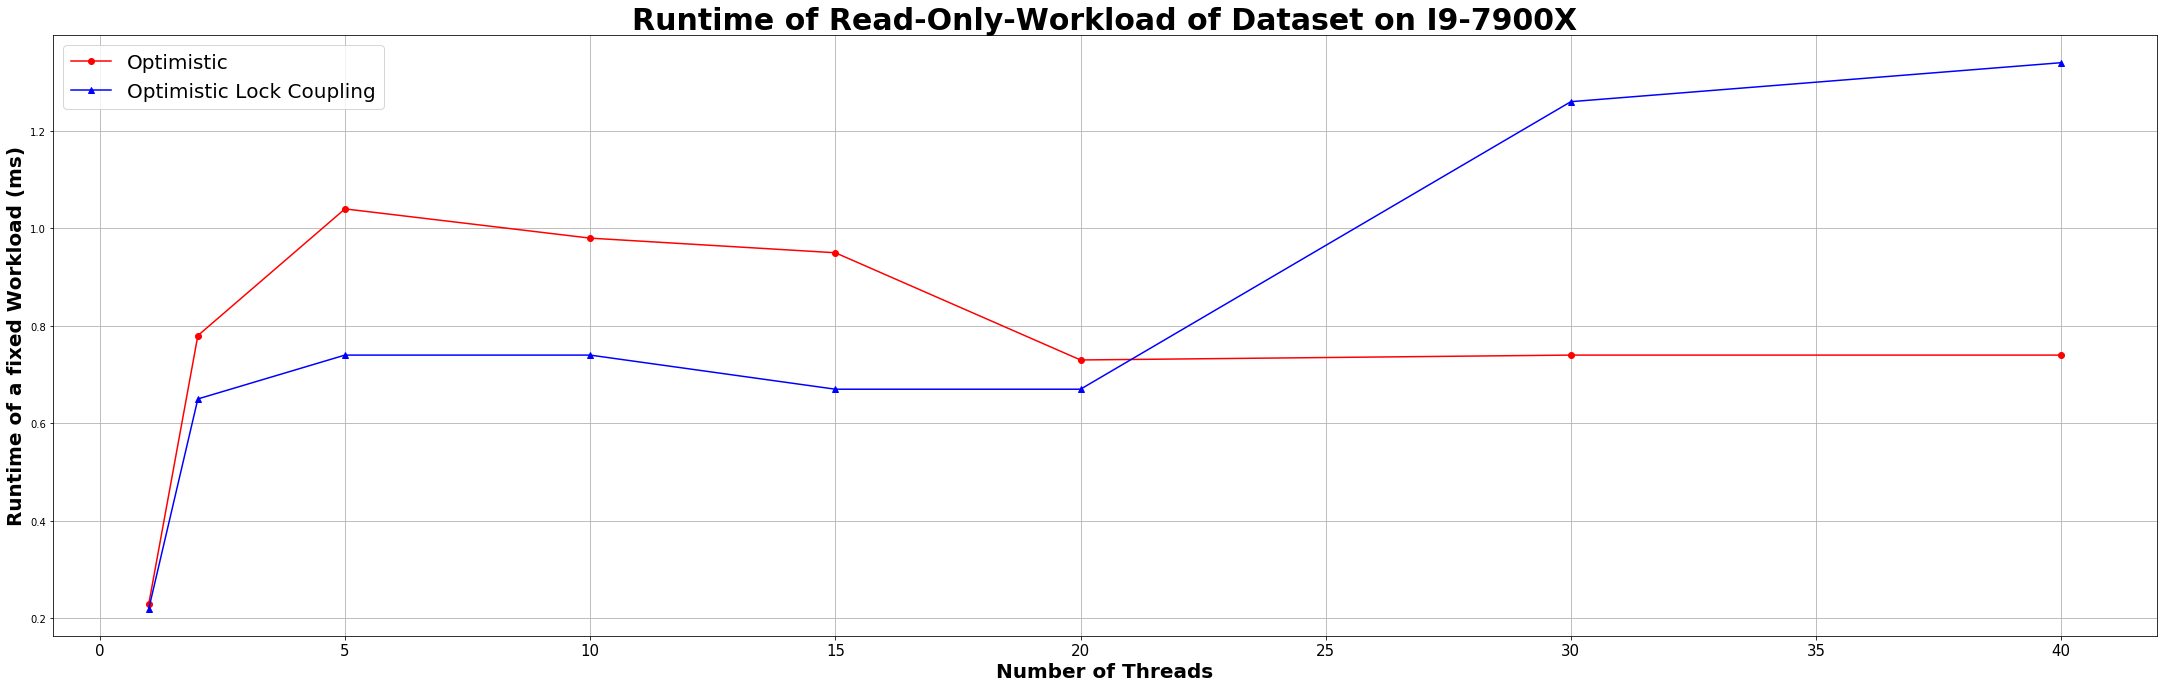

<Figure size 28800x14400 with 0 Axes>

In [15]:
df_o   = pd.read_csv("read_only_o.csv")
thread   = df_o['thread']
time_o   = df_o['time']

df_olc   = pd.read_csv("read_only_olc.csv")
time_olc   = df_olc['time']

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()

plt.plot(thread, time_o, 'ro-', thread, time_olc, 'b^-')

plt.title('Runtime of Read-Only-Workload of Dataset on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Threads', fontsize=20, fontweight='bold')
plt.ylabel('Runtime of a fixed Workload (ms)', fontsize=20, fontweight='bold')
plt.legend(['Optimistic', 'Optimistic Lock Coupling'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

### Mixed-Workload Evaluation

#### nosync

Actually, this is just a fake baseline, since it is not capable to do thread-safe work.

<br>
<br>

#### Coarse Lock

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.25| 1118332752.00| 1505467881.00| 1475178.00|  679977.00|   14183908.00| 249946704.00| 1.35| 1.00| 4.47 | 
|       2|     1.00| 7895682133.00| 2952599683.00| 29119587.00|  734029.00|   20867152.00| 1843532253.00| 0.37| 1.85| 4.28 | 
|       5|     1.35| 7818620667.00| 2417732587.00| 47365536.00|  241828.00|   13640713.00| 2077934674.00| 0.31| 1.53| 3.76 | 
|      10|     1.76| 51399767105.00| 12010582959.00| 280948925.00|  700855.00|   62580441.00| 13631764742.00| 0.23| 7.73| 3.77 | 
|      15|     2.06| 93781000812.00| 15767731064.00| 435311472.00|  706170.00|   72001484.00| 24636313482.00| 0.17| 11.95| 3.81 | 
|      20|     2.23| 142833194760.00| 18367743773.00| 519570021.00|  716180.00|   77596032.00| 37106558669.00| 0.13| 16.64| 3.85 | 
|      30|     2.24| 161934348952.00| 19597817571.00| 552585482.00|  771502.00|   82421569.00| 41144351147.00| 0.12| 18.34| 3.94 | 
|      40|     2.16| 4087778764.00| 476996953.00| 13220299.00|   18797.00|    1847117.00| 1053025259.00| 0.12| 0.49| 3.88 | 

<br>
<br>

#### Coarse RW Lock

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.24| 1070868526.00| 1259450883.00| 1482019.00|  705821.00|   14262478.00| 239253560.00| 1.18| 1.00| 4.48 |
|       2|     0.58| 5020588833.00| 1417292013.00| 16537277.00|  720687.00|   17230289.00| 1156879433.00| 0.28| 2.00| 4.34 |
|       5|     1.40| 11200313555.00| 1383590117.00| 21218139.00|  307275.00|   13194064.00| 2800165582.00| 0.12| 2.00| 4.00 |
|      10|     2.31| 92564714139.00| 12779519434.00| 98425692.00|  741659.00|   72548492.00| 23142555158.00| 0.14| 10.00| 4.00 |
|      15|     2.51| 150713578551.00| 22909886983.00| 170356749.00|  760056.00|  112233281.00| 37680462619.00| 0.15| 14.99| 4.00 |
|      20|     2.74| 219032593954.00| 34431914331.00| 266628328.00|  771841.00|  155356873.00| 54761374583.00| 0.16| 19.97| 4.00 |
|      30|     2.76| 219848167791.00| 43307152344.00| 351993910.00|  776179.00|  216868888.00| 54964474088.00| 0.20| 19.89| 4.00 |
|      40|     2.64| 210769338644.00| 50150824238.00| 423151778.00|  726397.00|  271651332.00| 52694363936.00| 0.24| 19.99| 4.00 |

`Coarse Lock` and `Coarse RW Lock` do not differ so much in the mixed-workload.

<br>
<br>

#### Lock Coupling

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.72| 3223606045.00| 4325982957.00| 2255960.00|  805811.00|   14087578.00| 720799256.00| 1.34| 1.00| 4.47 |
|       2|     4.30| 21410667493.00| 11328808448.00| 170465269.00|  837434.00|   36648292.00| 5480106814.00| 0.53| 1.28| 3.91 |
|       5|     3.63| 17362600650.00| 11440744242.00| 178704593.00|  760768.00|   34624356.00| 5053774368.00| 0.66| 1.39| 3.44 |
|      10|     3.63| 17300356303.00| 11439139239.00| 184374617.00|  778355.00|   35176238.00| 5038768121.00| 0.66| 1.39| 3.43 |
|      15|     3.52| 16676468166.00| 10902474631.00| 193185584.00|  816416.00|   34259837.00| 4849021265.00| 0.65| 1.38| 3.44 |
|      20|     3.46| 16365485855.00| 10714541948.00| 196944781.00|  832238.00|   34008082.00| 4756795084.00| 0.65| 1.37| 3.44 |
|      30|     3.42| 16341320287.00| 10584654595.00| 200340225.00|  883723.00|   34035853.00| 4729291101.00| 0.65| 1.38| 3.46 |
|      40|     3.40| 16324863024.00| 10559018934.00| 200166590.00|  902394.00|   34074162.00| 4718395733.00| 0.65| 1.39| 3.46 |

<br>
<br>

#### RW Lock Coupling

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.67| 3012485826.00| 3220610736.00| 1501926.00|  716008.00|   14418332.00| 672224371.00| 1.07| 1.00| 4.48 | 
|       2|     3.31| 28889733301.00| 3362140740.00| 204514111.00|  725715.00|   17543119.00| 6623056054.00| 0.12| 2.00| 4.36 | 
|       5|     3.96| 31713882025.00| 2607558018.00| 139278549.00|  292367.00|   18374296.00| 7928629241.00| 0.08| 2.00| 4.00 | 
|      10|     4.47| 17866940281.00| 2249028436.00| 35445904.00|   73532.00|   11510142.00| 4466782874.00| 0.13| 1.00| 4.00 | 
|      15|     4.52| 18095005646.00| 2836126954.00| 30865712.00|   61499.00|   13096717.00| 4523804137.00| 0.16| 1.00| 4.00 | 
|      20|     4.61| 18435282345.00| 2867679347.00| 26801636.00|   38396.00|   12266564.00| 4608886952.00| 0.16| 1.00| 4.00 | 
|      30|     4.64| 370095011398.00| 75472816332.00| 730433249.00|  774060.00|  365405878.00| 92526452157.00| 0.20| 19.94| 4.00 | 
|      40|     4.47| 357297445097.00| 87515183791.00| 856584505.00|  779286.00|  464806463.00| 89326978393.00| 0.24| 19.99| 4.00 |

<br>
<br>

#### Optimistic

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.34| 1493054688.00| 2161295994.00| 2237298.00|  804248.00|   14480299.00| 336360733.00| 1.45| 1.00| 4.44 |
|       2|     1.57| 12429525143.00| 2980194521.00| 100764070.00|  820963.00|   18027936.00| 2894486710.00| 0.24| 1.84| 4.29 |
|       5|     1.59| 13541424775.00| 5030220881.00| 112458274.00|  766717.00|   27997083.00| 3629060044.00| 0.37| 2.28| 3.73 |
|      10|     1.50| 11629733745.00| 5290893048.00| 106598102.00|  775427.00|   27984328.00| 3186150466.00| 0.45| 2.13| 3.65 |
|      15|     1.47| 10870386298.00| 5082694498.00| 108142655.00|  800606.00|   27862428.00| 2987986111.00| 0.47| 2.04| 3.64 |
|      20|     1.47| 10708791121.00| 5031353596.00| 109830409.00|  815188.00|   27898395.00| 2946552321.00| 0.47| 2.01| 3.63 |
|      30|     1.47| 10906604963.00| 5048742911.00| 113366906.00|  847437.00|   28350896.00| 2992144321.00| 0.46| 2.04| 3.65 |
|      40|     1.48| 10974646419.00| 5073117109.00| 115220010.00|  876256.00|   28603454.00| 3012792795.00| 0.46| 2.03| 3.64 |

<br>
<br>

#### Optimistic Lock Coupling

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|     0.30| 1326337071.00| 1578646559.00| 1867913.00|  760492.00|   13693745.00| 298138514.00| 1.19| 1.00| 4.45 |
|       2|     1.14| 9958955340.00| 1785515212.00| 78975122.00|  776763.00|   14331213.00| 2283833768.00| 0.18| 2.00| 4.36 |
|       5|     1.67| 13368142948.00| 1095115471.00| 80960336.00|  312948.00|   12546050.00| 3342123269.00| 0.08| 2.00| 4.00 |
|      10|     1.82| 7296847189.00| 851678348.00| 25680702.00|   81027.00|    6277939.00| 1824234759.00| 0.12| 1.00| 4.00 |
|      15|     1.82| 7282268276.00| 1212441247.00| 20909121.00|   64858.00|    7084845.00| 1820593781.00| 0.17| 1.00| 4.00 |
|      20|     1.86| 7448096083.00| 1265260538.00| 15208606.00|   41798.00|    6688909.00| 1862053164.00| 0.17| 1.00| 4.00 |
|      30|     1.85| 148075689675.00| 34137986158.00| 372941389.00|  834008.00|  189511632.00| 37021515518.00| 0.23| 19.97| 4.00 |
|      40|     2.09| 166257378015.00| 46189524900.00| 493322653.00|  838657.00|  248085209.00| 41565602575.00| 0.28| 19.87| 4.00 |

<br>
<br>

This time **only two** locks scale in this workload: Optimistic Lock Coupling, Optimistic. This result match our expectation, since the other are just well-known non-scalable approaches. So I just study these two more deeply and did some observations:
- As said these two approaches has 10 attempts to try to do the work in a optimistic way. It is generally to see a trend, that `Optimistic` can live within the 10 times trying, while `Optimistic Lock Coupling` is suffering more failures and fall-back. I did only observe this behavior but not record it, since I found this behavior is super-heavy relying of the number of attempts and the length of list (or the size of the domain-set / domain-value-range). In this dataset, the length of list is rather small (since the domain is just 16), it makes the version-number of `Optimistic Lock Coupling` not trustable, since all the threading is contesting only a few nodes. `Optimistic` seems to have a way with less parallelism by using lock more frequently, but it turns out that it also has higher possibility to success within 10 time trying.
- `Optimistic Lock Coupling` has more failing cases so potentially more iterations to run. So it has lower IPC than the `Optimistic`.
- `Optimistic` has more L1 and LLC cache misses, since it is validating with traversing the list again. But in the opposite, the `Optimistic Lock Coupling` just checking and validating locally the version-number again, thus it can definitely less cache-miss-ratio.

Again the hyper-threading area (> 20 threads) is less important than the normal threading area ( <= 20 threads). 

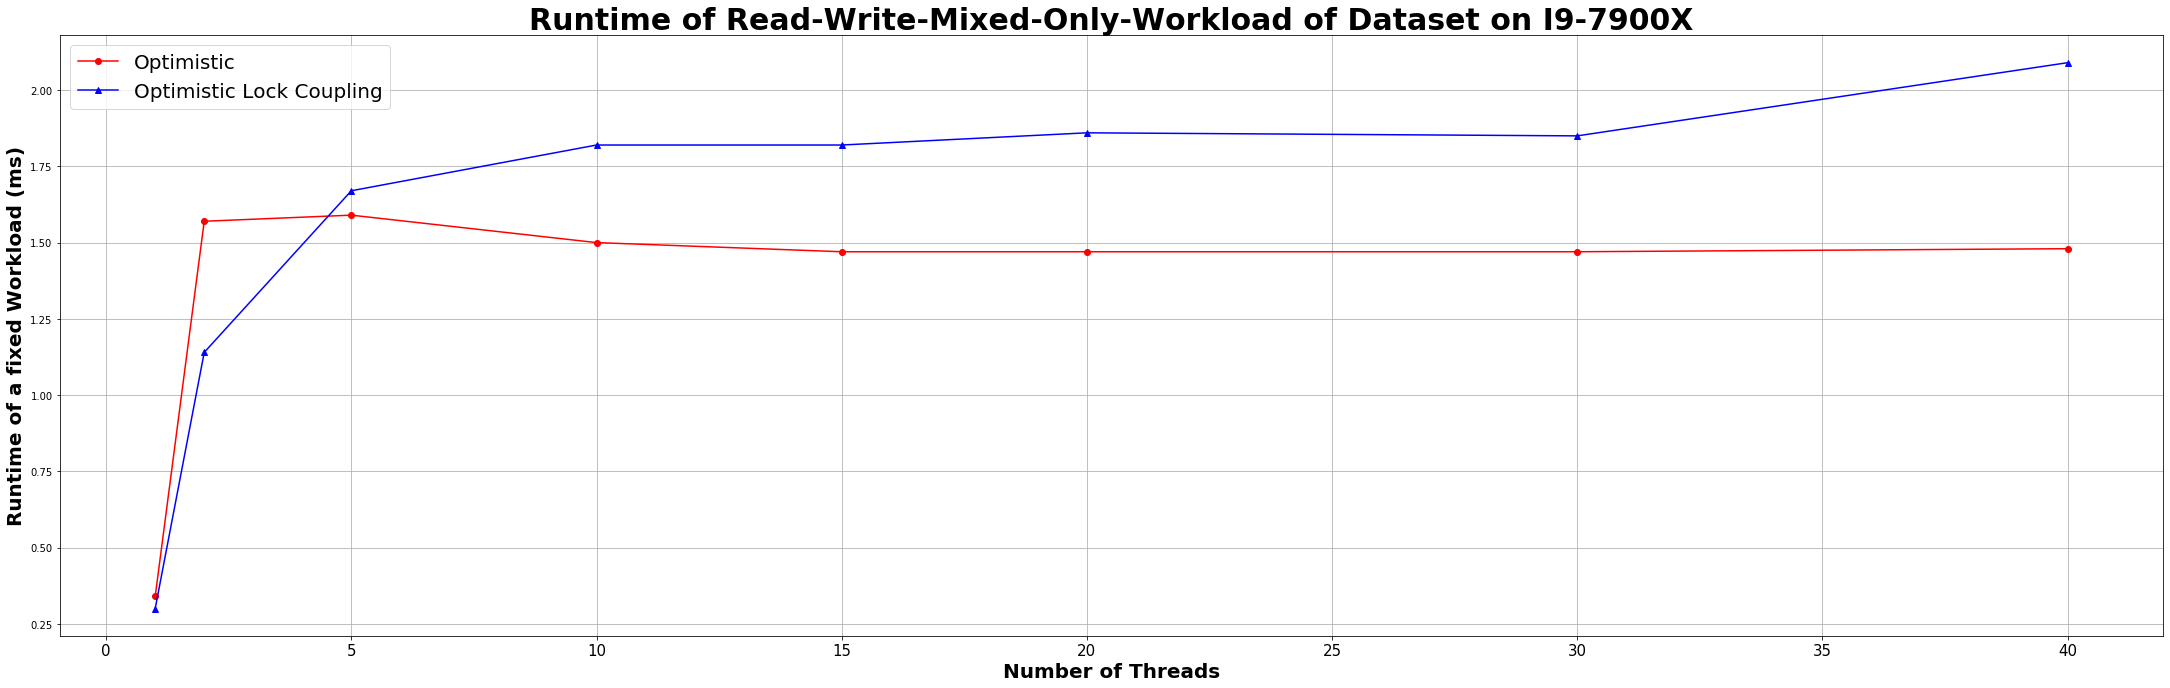

<Figure size 28800x14400 with 0 Axes>

In [13]:
df_o   = pd.read_csv("mix_o.csv")
thread   = df_o['thread']
time_o   = df_o['time']

df_olc   = pd.read_csv("mix_olc.csv")
time_olc   = df_olc['time']

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()

plt.plot(thread, time_o, 'ro-', thread, time_olc, 'b^-')

plt.title('Runtime of Read-Write-Mixed-Only-Workload of Dataset on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Threads', fontsize=20, fontweight='bold')
plt.ylabel('Runtime of a fixed Workload (ms)', fontsize=20, fontweight='bold')
plt.legend(['Optimistic', 'Optimistic Lock Coupling'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()


# Conclustion

We know the fact and expect that the `Optimistic` and `Optimistic Lock Coupling` is two only scalable ways among all approaches in this homework. The result can reflect this expectation. For the time reason, I did not plot all non-scalable approaches, since from the micro-benchmark table, we can infer the runtime of them is significant higher.

I do not have so many word about this homework. I think it is also common by other students, that adding more threads is not accelerating and no linear speed-up on the scalar code. Somehow, I am adding more threads to let the problem running slower, and to see which locking strategy can have the lest slightly negative impact on this problem. 

I think the slowing is because the real work (read/insert/delete) is actually light-weighted enough --  the list is not larger than the LLC in general (despite of the size of mutex). Invite 40 threads to this list and synchronize these 40 threads takes over the runtime, while the overhead read/insert/delete is becoming minor and minor. So I don't see any speed-up on the throughput in my implementation and evaluation -- as well as I do not expect they to happen.    

OLTP or transaction is generally not memory intensive, but it still some work. Another thing is that in databases, transactions are touching different partitions of the relation, since the relation itself is decoupled and fragmented like in HTAP systems. But in our cases, we are intended to coupled the list together, which makes the dependency between nodes very high. It is hard to parallelize these high-dependency *correctly* and have a linear speed-up.

# Appendix

## Experiment Environment

All the experiments are performed on a Core i9-7900X - Intel: https://en.wikichip.org/wiki/intel/core_i9/i9-7900x

# TODO & Quesstion: 
1. A good way to do code refactoring, to eliminate the duplicated ugly parts.
2. It is strange to see, the performance is at same level (or even better) in the hyper-threading area (more than 20 threads). Somehow I hope to a significant slowing-down. But I think is because of multi-threading noisy and did not go deep. This issue make the plot bit strange and I expect a increasement of runtime at the right of the two plots.